In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Define functions

In [152]:
def read_csv(file_name, metric_name):
    df = pd.read_csv(f'inputs/{file_name}_{metric_name}.csv')
    return df

def filter_by_technology(df, metric_name, technologies_of_interest):
    df = df[df['techs'].isin(technologies_of_interest)]
    aggregated_df = df.groupby(['spore', 'techs'])[f'{metric_name}'].sum().reset_index()
    return aggregated_df

def filter_by_technology_cost_opt(df, metric_name, technologies_of_interest):
    df = df[df['techs'].isin(technologies_of_interest)]
    aggregated_df = df.groupby(['techs'])[f'{metric_name}'].sum().reset_index()
    return aggregated_df

def filter_by_carrier(df, metric_name, carrier_of_interest, total=False):
    df = df[df['carriers'].isin(carrier_of_interest)]
    aggregated_df = df.groupby(['spore'])[f'{metric_name}'].sum().reset_index() if total else df.groupby(['spore', 'techs'])[f'{metric_name}'].sum().reset_index()
    return aggregated_df

def max_min_capacity_by_tech(aggregated_df, metric_name):
    max_capacity_by_tech = aggregated_df.groupby('techs')[f'{metric_name}'].max()
    min_capacity_by_tech = aggregated_df.groupby('techs')[f'{metric_name}'].min()
    return max_capacity_by_tech, min_capacity_by_tech

def normalize_capacity(aggregated_df, metric_name, max_capacity_by_tech, min_capacity_by_tech, normalize_by_optimal_solution=False):
    if not normalize_by_optimal_solution:
      aggregated_df[f'normalized_{metric_name}'] = aggregated_df.apply(
           lambda row: (row[f'{metric_name}'] - min_capacity_by_tech[row['techs']]) / (max_capacity_by_tech[row['techs']]- min_capacity_by_tech[row['techs']]), axis=1)
    else:
      aggregated_df[f'normalized_{metric_name}_cost_opt'] = aggregated_df.apply(
           lambda row: row[f'{metric_name}'] / max_capacity_by_tech[row['techs']], axis=1)
    return aggregated_df

def plot_initialization(technologies_of_interest):
    np.random.seed(0)  # For reproducibility
    colors = np.random.rand(len(technologies_of_interest), 3)  # Generate as many colors as there are technologies
    tech_color_dict = dict(zip(technologies_of_interest, colors))
    return tech_color_dict

def plot_distribution(aggregated_df, metric_name, file_name, tech_color_dict=False):
    plt.figure(figsize=(10, 6))
    # sns.violinplot(x='techs', y=metric_name, data=aggregated_df, palette=tech_color_dict, inner="quart")
    sns.boxplot(x='techs', y=metric_name, data=aggregated_df, palette=tech_color_dict) if tech_color_dict else sns.boxplot(x='techs', y=metric_name, data=aggregated_df)
    
    plt.xlabel('Technology', fontsize=14)

    # Get original labels
    xticklabels = [item.get_text() for item in plt.gca().get_xticklabels()]
    xlabel = plt.gca().get_xlabel()
    ylabel = plt.gca().get_ylabel()

    # Replace "_" with space and capitalize first letter
    xticklabels = [label.replace("_", " ").capitalize() for label in xticklabels]
    xlabel = xlabel.replace("_", " ").capitalize()
    ylabel = ylabel.replace("_", " ").capitalize()

    if metric_name.startswith('nameplate'):
        ylabel = f'{ylabel} (TW)'
    elif metric_name.startswith('flow'):
        ylabel = f'{ylabel} (TWh)'

    # Set new labels
    plt.gca().set_xticklabels(xticklabels)
    plt.gca().set_xlabel(xlabel)
    plt.gca().set_ylabel(ylabel, fontsize=14)

    plt.gca().set_ylim([0, 10]) # only for offshore 

    plt.tick_params(axis='both', which='major', labelsize=12, rotation=45)

    plt.savefig(f'outputs/{metric_name}_distribution_{file_name}.png', dpi=300, format='png', bbox_inches='tight')
    plt.show()

def split_by_percentile_or_value(aggregated_df, tech, metric_name, value, is_percentile=True):
    if is_percentile:
        # Convert percentile to a proportion
        value = value / 100.0
        threshold = aggregated_df[aggregated_df['techs'] == tech][metric_name].quantile(value)
    else:
        threshold = value
    
    # Identify 'spore' values where 'nuclear' normalized_capacity is either above or below the 75th percentile
    above = aggregated_df[(aggregated_df['techs'] == tech) & (aggregated_df[metric_name] >= threshold)]['spore']
    below = aggregated_df[(aggregated_df['techs'] == tech) & (aggregated_df[metric_name] < threshold)]['spore']

    # Filter the DataFrame to only include rows from these 'spores' for both cases
    above_df = aggregated_df[aggregated_df['spore'].isin(above)]
    below_df = aggregated_df[aggregated_df['spore'].isin(below)]
    
    return above_df, below_df

def find_spore_index(df, tech, sense, metric_name):
    if sense == "min":
        index = df[df['techs']==tech][metric_name].idxmax()
    elif sense == 'min':
        index = df[df['techs']==tech][metric_name].idxmin()
    spore = df[df['techs']==tech].loc[index, 'spore']
    return spore    

def create_subplots(aggregated_df, tech, metric_name, percentile, above_df, below_df, tech_color_dict, file_name, show_lineplot=False, interested_spores=None):
    # Create subplots

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    sns.swarmplot(ax=axes[0], x='techs', y=f'{metric_name}', data=aggregated_df, palette=tech_color_dict)
    axes[0].set_title('All spores')
    
    if show_lineplot and interested_spores is not None:
        filtered_df = aggregated_df[aggregated_df['spore'].isin(interested_spores)]
        sns.lineplot(ax=axes[0], x='techs', y=f'{metric_name}', hue='spore', data=filtered_df, palette='tab10', legend=False)

    sns.swarmplot(ax=axes[1], x='techs', y=f'{metric_name}', data=above_df, palette=tech_color_dict)
    axes[1].set_title(f'Spores > {percentile}th percentile of {tech}')
    

    sns.swarmplot(ax=axes[2], x='techs', y=f'{metric_name}', data=below_df, palette=tech_color_dict)
    axes[2].set_title(f'Spores < {percentile}th percentile of {tech}')

    # Set common labels
    for ax in axes:
        ax.set_xlabel('Technology', fontsize=12)
        xticklabels = [item.get_text() for item in ax.get_xticklabels()]
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()

        # Replace "_" with space and capitalize first letter
        xticklabels = [label.replace("_", " ").capitalize() for label in xticklabels]
        xlabel = xlabel.replace("_", " ").capitalize()
        ylabel = ylabel.replace("_", " ").capitalize()

        if metric_name.startswith('nameplate'):
            ylabel = f'{ylabel} (TW)'
        elif metric_name.startswith('flow'):
            ylabel = f'{ylabel} (TWh)'

        # Set new labels
        ax.set_xticklabels(xticklabels)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel, fontsize=12)

        ax.tick_params(axis='both', which='major', labelsize=8.5)

    plt.tight_layout()
    plt.savefig(f'outputs/subplots_stripplot_{metric_name}_{tech}_{percentile}pct_{file_name}.png', dpi=300, format='png')
    plt.show()

    
def prepare_corr_matrix(df, metric_name, interested_techs):
    filtered_df = df[df['techs'].isin(interested_techs)]
    pivot_df = filtered_df.pivot(index='spore', columns='techs', values=f'{metric_name}')
    pivot_df_cleaned = pivot_df.dropna()
    return pivot_df_cleaned.corr()

def create_correlation_heat_maps(metric_name, percentile, corr_matrix_aggregated, corr_matrix_above, corr_matrix_below):

    fig, axs = plt.subplots(1, 3, figsize=(15, 4)) 

    sns.heatmap(corr_matrix_aggregated, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axs[0])
    axs[0].set_title('All spores')

    sns.heatmap(corr_matrix_above, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axs[1])
    axs[1].set_title(f'Spores > {percentile}th percentile of nuclear')

    sns.heatmap(corr_matrix_below, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axs[2])
    axs[2].set_title(f'Spores > {percentile}th percentile of nuclear')

    # Set common labels
    for ax in axs:
        # Get original labels
        xticklabels = [item.get_text() for item in ax.get_xticklabels()]
        yticklabels = [item.get_text() for item in ax.get_yticklabels()]

        # Replace "_" with space and capitalize first letter
        xticklabels = [label.replace("_", " ").capitalize() for label in xticklabels]
        yticklabels = [label.replace("_", " ").capitalize() for label in yticklabels]

        if metric_name.startswith('nameplate'):
            ylabel = f'{ylabel} (TW)'
        elif metric_name.startswith('flow'):
            ylabel = f'{ylabel} (TWh)'

        # Set new labels
        ax.set_xticklabels(xticklabels)
        ax.set_yticklabels(yticklabels)
        ax.set_xlabel("")
        ax.set_ylabel("")

        ax.tick_params(axis='both', which='major', labelsize=8.5, rotation=45)

    plt.tight_layout()
    plt.savefig(f'outputs/subplots_{metric_name}_correlation_{file_name}.png', dpi=300, format='png')
    plt.show()



Check data: demand, supply

In [109]:
file_name = "slack-15"
metric_names = ['flow_in_sum', 'flow_out_sum']
dfs = []                                    
for metric_name in metric_names:        
    df = read_csv(file_name, metric_name)
    carrier_of_interest = ['hydrogen']
    aggregated_df_c = filter_by_carrier(df, metric_name, carrier_of_interest, total=False) #NOTE:change total to True to get total capacity
    dfs.append(aggregated_df_c)
    

C:\Users\wangn\AppData\Local\Temp\ipykernel_6236\1832290078.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


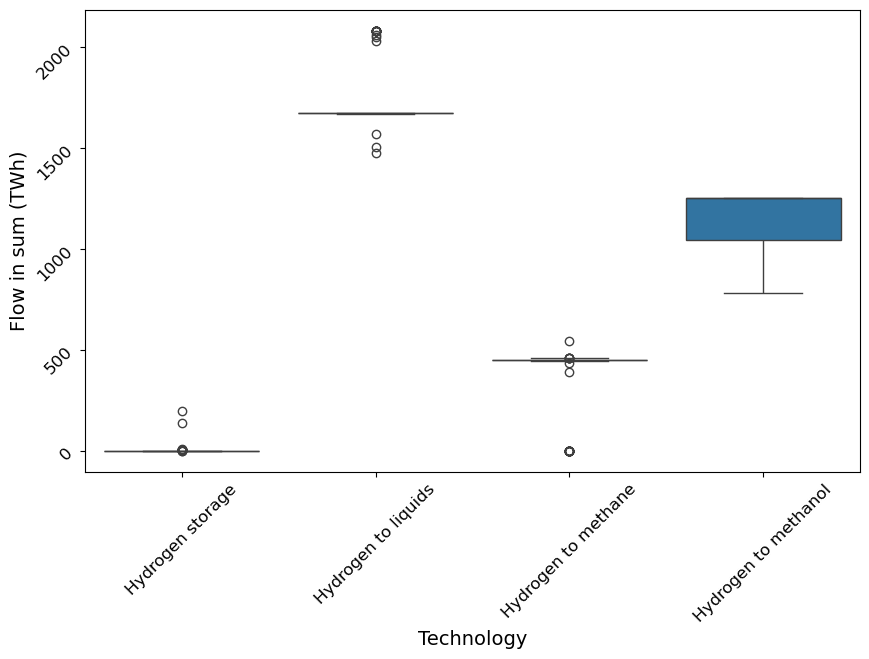

In [113]:
plot_distribution(dfs[0], metric_names[0], file_name, tech_color_dict=False)

Combine wind offshore and onshore to wind total

In [82]:
technologies_of_interest = ['wind_offshore', 'wind_onshore', 'electrolysis']
aggregated_df = filter_by_technology(df, metric_name, technologies_of_interest)
aggregated_df
# Create a copy of the Data         Frame to avoid modifying the original one
df_copy = df.copy()
# Combine 'wind_offshore' and 'wind_onshore' into 'wind_total'
df_copy.loc[df_copy['techs'].isin(['wind_offshore', 'wind_onshore']), 'techs'] = 'wind_total'
technologies_of_interest = ['wind_total', 'electrolysis']
aggregated_df_t = filter_by_technology(df_copy, metric_name, technologies_of_interest)
prepare_corr_matrix(aggregated_df_t, metric_name, technologies_of_interest)


techs,electrolysis,wind_total
techs,,
electrolysis,1.000000,0.448701
wind_total,0.448701,1.000000


Plot H2 balance, renaming storage to supply & demand

c:\Users\wangn\AppData\Local\miniforge3\envs\calliope\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 70.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\wangn\AppData\Local\miniforge3\envs\calliope\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 88.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\wangn\AppData\Local\miniforge3\envs\calliope\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 76.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\wangn\AppData\Local\miniforge3\envs\calliope\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 87.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, U

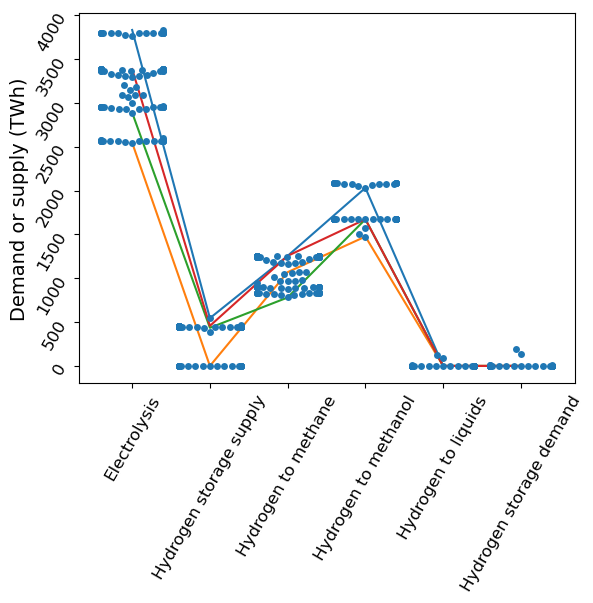

In [98]:
dfs = []
new_metric_name = 'demand or supply'
old_tech_name = 'hydrogen_storage'
for metric_name in metric_names:
    df = read_csv(file_name, metric_name)
    df = df[df['carriers'].isin(['hydrogen'])]
    # aggregated_df = df.groupby(['spore', 'techs'])[f'{metric_name}'].sum().reset_index()
    total_df = df.groupby(['spore'])[f'{metric_name}'].sum().reset_index()
    separate_df = df.groupby(['spore', 'techs'])[f'{metric_name}'].sum().reset_index()
    separate_df['techs'] = separate_df['techs'].replace({old_tech_name: old_tech_name + "_supply" if metric_name==metric_names[1] else old_tech_name + "_demand"})
    separate_df = separate_df.rename(columns={metric_name: new_metric_name})
    dfs.append(separate_df)

combined_df = pd.concat(dfs).reset_index(drop=True)
combined_df = combined_df.sort_values(by='spore').reset_index(drop=True)
combined_df.head(10)

# add missing techs (i.e., all tech must have a value for each spore)
pivot_df = combined_df.pivot_table(index='spore', columns='techs', values=new_metric_name, fill_value=0).reset_index()
melt_df = pivot_df.melt(id_vars='spore', value_name=new_metric_name).sort_values(by='spore')
combined_df = melt_df


sns.swarmplot(x='techs', y=new_metric_name, data=combined_df, dodge=True)
plt.xticks(rotation=90)

interested_spores = [93, 97, 162, 8] 
filtered_df = combined_df[combined_df['spore'].isin(interested_spores)]
sns.lineplot(x='techs', y=new_metric_name, hue='spore', data=filtered_df, palette='tab10', legend=False)
# plt.savefig('outputs/electrolysis_outliers_h2_demand_supply_absolute.png', dpi=300, format='png', bbox_inches='tight')


# Get original labels
xticklabels = [item.get_text() for item in plt.gca().get_xticklabels()]
xlabel = plt.gca().get_xlabel()
ylabel = plt.gca().get_ylabel()

# Replace "_" with space and capitalize first letter
xticklabels = [label.replace("_", " ").capitalize() for label in xticklabels]
xlabel = xlabel.replace("_", " ").capitalize()
ylabel = ylabel.replace("_", " ").capitalize()

xlabel = ''
ylabel = f'{ylabel} (TWh)'

# Manually define the order
order = [xticklabels[0], xticklabels[4], xticklabels[1], xticklabels[2], xticklabels[3], xticklabels[5]] 
mapping = {label: value for value, label in enumerate(order)}
xticklabels = sorted(xticklabels, key=lambda label: mapping[label])

# Set new xticks and xtick labels
plt.gca().set_xticks(range(len(xticklabels)))
plt.gca().set_xticklabels(xticklabels)

# Set new labels
plt.gca().set_xlabel(xlabel)
plt.gca().set_ylabel(ylabel, fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=12, rotation=60)

plt.savefig(f'outputs/{metric_name}_distribution_{file_name}.png', dpi=300, format='png', bbox_inches='tight')
plt.show()



To fix the "Unexpected indentation" problem, remove the commented line `# metric_name = metric_names[0]` from the code block. 

Define parameters

In [149]:
# Parameters
file_name = "slack-15"
metric_names = ['nameplate_capacity', 'flow_out_sum']
processed_metric_names = ['nameplate_capacity', 'flow_out_sum', 'normalized_nameplate_capacity', 'normalized_flow_out_sum', 'normalized_nameplate_capacity_cost_opt', 'normalized_flow_out_sum_cost_opt']
active_name = processed_metric_names[4]
technologies_of_interest = ['nuclear', 'wind_offshore', 'wind_onshore', 'electrolysis', 'battery']

Data preparation: filtering and normalization

In [150]:

dfs = []
aggregated_dfs = []
for metric_name in metric_names:
    df = read_csv(file_name, metric_name)
    dfs.append(df)
    aggregated_df = filter_by_technology(df, metric_name, technologies_of_interest)
    max_capacity_by_tech, min_capacity_by_tech = max_min_capacity_by_tech(aggregated_df, metric_name)
    normalize_capacity(aggregated_df, metric_name, max_capacity_by_tech, min_capacity_by_tech, normalize_by_optimal_solution=False)
    cost_opt_df = read_csv("cost-opt", metric_name)
    cost_opt_df = filter_by_technology_cost_opt(cost_opt_df[cost_opt_df['weather_year']==2018], metric_name, technologies_of_interest)
    max_capacity_by_tech_cost_opt, min_capacity_by_tech_cost_opt = max_min_capacity_by_tech(cost_opt_df, metric_name)
    # print(max_capacity_by_tech_cost_opt, min_capacity_by_tech_cost_opt)
    normalize_capacity(aggregated_df, metric_name, max_capacity_by_tech_cost_opt, min_capacity_by_tech_cost_opt, normalize_by_optimal_solution=True)
    
    aggregated_dfs.append(aggregated_df)

aggregated_df = pd.concat(aggregated_dfs, axis=1)
aggregated_df = aggregated_df.loc[:, ~aggregated_df.columns.duplicated()]


Plot distribution

C:\Users\wangn\AppData\Local\Temp\ipykernel_6236\136578805.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='techs', y=metric_name, data=aggregated_df, palette=tech_color_dict) if tech_color_dict else sns.boxplot(x='techs', y=metric_name, data=aggregated_df)
C:\Users\wangn\AppData\Local\Temp\ipykernel_6236\136578805.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


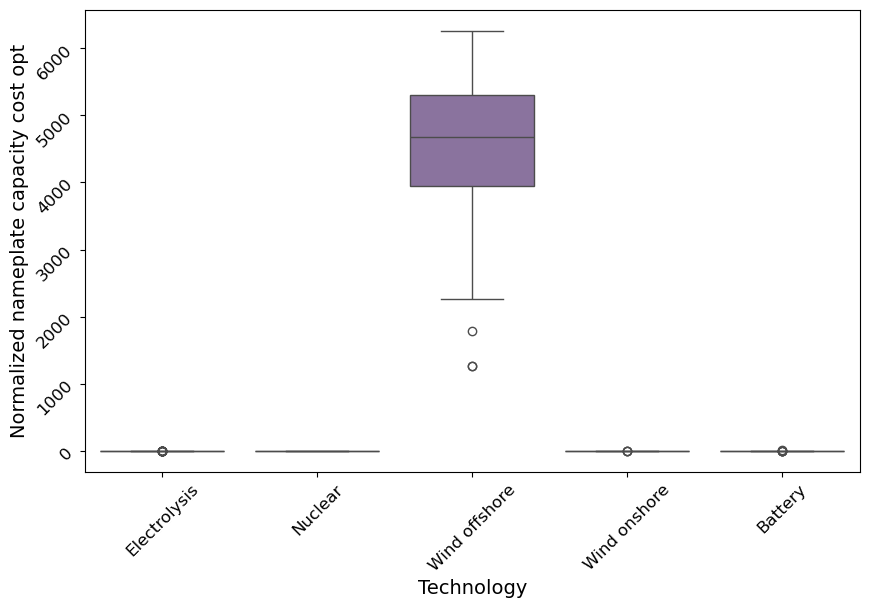

In [151]:
tech_color_dict = plot_initialization(technologies_of_interest)
plot_distribution(aggregated_df, active_name, file_name, tech_color_dict)


Plot subplots of stripplots

C:\Users\wangn\AppData\Local\Temp\ipykernel_6236\1128510101.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(ax=axes[0], x='techs', y=f'{metric_name}', data=aggregated_df, palette=tech_color_dict)
c:\Users\wangn\AppData\Local\miniforge3\envs\calliope\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\wangn\AppData\Local\miniforge3\envs\calliope\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\wangn\AppData\Local\miniforge3\envs\calliope\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 23.2% of the points cannot

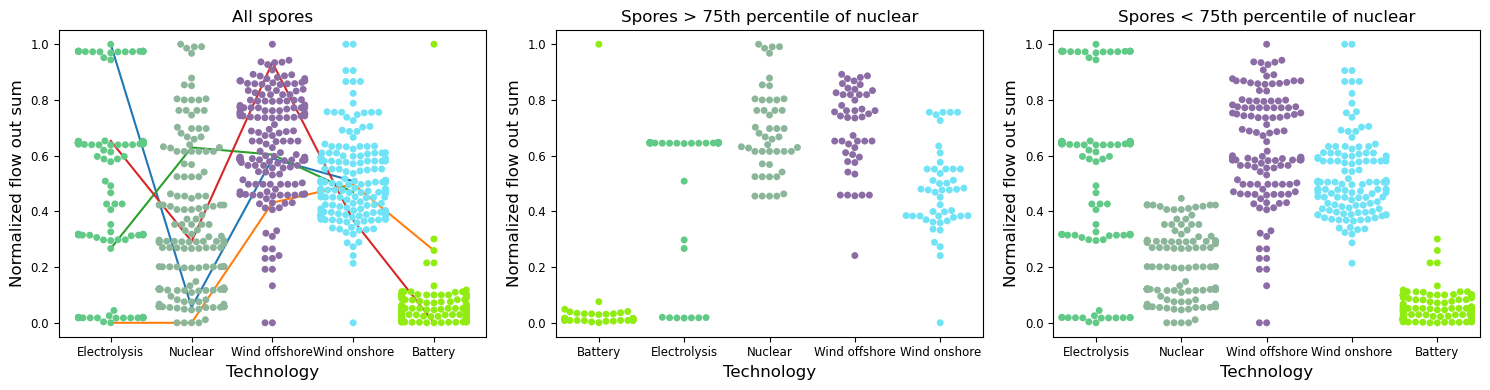

In [80]:
above_df, below_df = split_by_percentile_or_value(aggregated_df, 'nuclear', active_name, 75, is_percentile=True) # NOTE:for electrolysis, the threshold is 0.1; for nuclear, the threshold is 75.
create_subplots(aggregated_df, 'nuclear', active_name, 75, above_df, below_df, tech_color_dict, file_name, show_lineplot=True, interested_spores=[93, 97, 162, 8]) #NOTE: for electrolysis, the interested spores are [93, 97, 162, 8], using find_spore_index().


Plot heat maps for correlation analysis

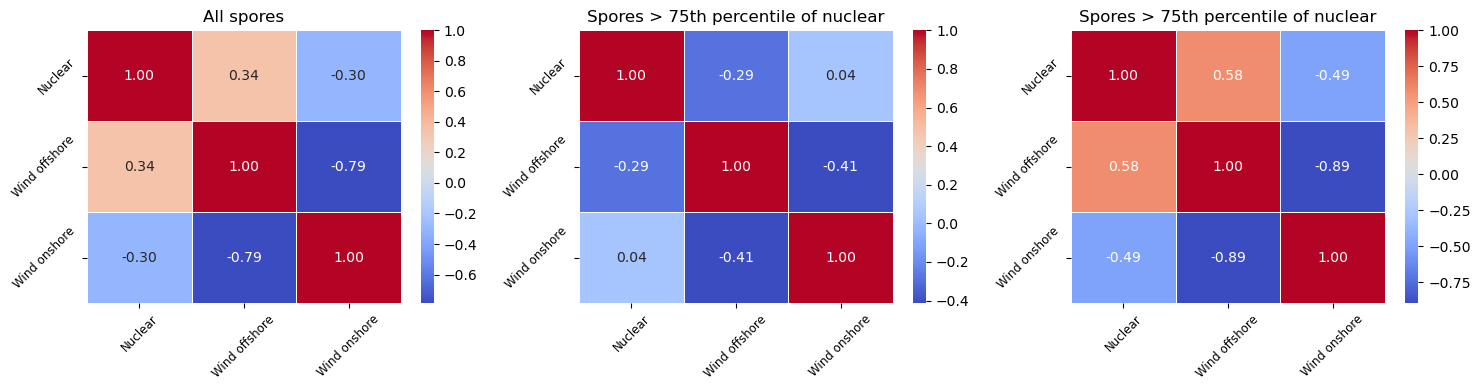

In [79]:

interested_techs_correlation = ['nuclear', 'wind_offshore', 'wind_onshore']
corr_matrix_aggregated = prepare_corr_matrix(aggregated_df, active_name, interested_techs_correlation)
corr_matrix_above = prepare_corr_matrix(above_df, active_name, interested_techs_correlation)
corr_matrix_below = prepare_corr_matrix(below_df, active_name, interested_techs_correlation)

create_correlation_heat_maps(active_name, 75, corr_matrix_aggregated, corr_matrix_above, corr_matrix_below)